Performing Maximum Likelihood Estimation of the autocorrelation parameters...
The chosen optimizer is: fmin_cobyla


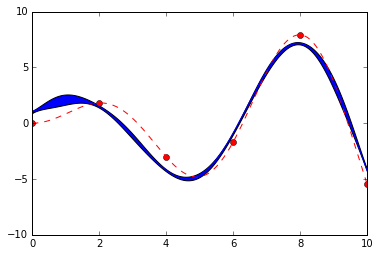

In [1]:
# Example 1.
import numpy as np
from sklearn import gaussian_process
import matplotlib.pyplot as plt
%matplotlib inline
def f(x):
    return x * np.sin(x)
X = np.atleast_2d(np.linspace(0, 10, 6)).T
noise = np.random.randn(len(X)) * 1
y = f(X).ravel()
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
gp = gaussian_process.GaussianProcess(
    regr='constant',
    corr='squared_exponential',
    beta0=None,           # Regression weight of Ordinary Kriging
    storage_mode='full',  # Store Cholesky decomposition of Corr.
    theta0=0.1,           # Parameters of autocorrelation
    thetaL=1e-4,          # Lower-bound parameters
    thetaU=1,           # Upper-bound parameters
    normalize=True,       # Standard Gaussian normalization of input
    nugget=1e-3,  # 2.22e-15,
    optimizer='fmin_cobyla',
    verbose=True
)
gp.fit(X, y + noise)  
y_pred, sigma2_pred = gp.predict(x, eval_MSE=True)
x = x.flatten()

# Plotting
plt.plot(X,y,'or')
plt.plot(x,f(x).ravel(), '--r')
plt.plot(x, y_pred)
plt.fill_between(x, y_pred - sigma2_pred, y_pred + sigma2_pred)
plt.ylim([-10,10])
plt.show()

Given autocorrelation parameters. Computing Gaussian Process model parameters...


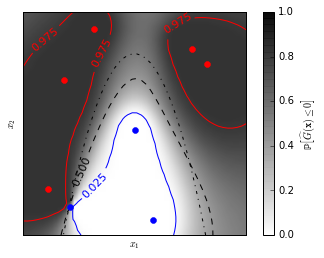

In [2]:
# Example 2.
import numpy as np
from scipy import stats
from sklearn.gaussian_process import GaussianProcess
from matplotlib import pyplot as pl
from matplotlib import cm
%matplotlib inline

# Standard normal distribution functions
phi = stats.distributions.norm().pdf
PHI = stats.distributions.norm().cdf
PHIinv = stats.distributions.norm().ppf

# A few constants
lim = 8

def g(x):
    """The function to predict (classification will then consist in predicting
    whether g(x) <= 0 or not)"""
    return 5. - x[:, 1] - .5 * x[:, 0] ** 2.

# Design of experiments
X = np.array([[-4.61611719, -6.00099547],
              [4.10469096, 5.32782448],
              [0.00000000, -0.50000000],
              [-6.17289014, -4.6984743],
              [1.3109306, -6.93271427],
              [-5.03823144, 3.10584743],
              [-2.87600388, 6.74310541],
              [5.21301203, 4.26386883]])

# Observations
y = g(X)

# Instanciate and fit Gaussian Process Model
gp = GaussianProcess(
    regr='constant',
    corr='squared_exponential',
    beta0=None,           # Regression weight of Ordinary Kriging
    storage_mode='full',  # Store Cholesky decomposition of Corr.
    theta0=5e-1,          # Parameters of autocorrelation
    # thetaL=1e-4,          # Lower-bound parameters
    # thetaU=1,             # Upper-bound parameters
    normalize=True,       # Standard Gaussian normalization of input
    nugget=1e-3,          # 2.22e-15,
    optimizer='fmin_cobyla',
    verbose=True
)

# Don't perform MLE or you'll get a perfect prediction for this simple example!
gp.fit(X, y)

# Evaluate real function, the prediction and its MSE on a grid
res = 50
x1, x2 = np.meshgrid(np.linspace(- lim, lim, res),
                     np.linspace(- lim, lim, res))
xx = np.vstack([x1.reshape(x1.size), x2.reshape(x2.size)]).T

y_true = g(xx)
y_pred, MSE = gp.predict(xx, eval_MSE=True)
sigma = np.sqrt(MSE)
y_true = y_true.reshape((res, res))
y_pred = y_pred.reshape((res, res))
sigma = sigma.reshape((res, res))
k = PHIinv(.975)

# Plot the probabilistic classification iso-values using the Gaussian property
# of the prediction
fig = pl.figure(1)
ax = fig.add_subplot(111)
ax.axes.set_aspect('equal')
pl.xticks([])
pl.yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
pl.xlabel('$x_1$')
pl.ylabel('$x_2$')

cax = pl.imshow(
    np.flipud(PHI(- y_pred / sigma)), 
    cmap=cm.gray_r, alpha=0.8,
    extent=(- lim, lim, - lim, lim)
)
norm = pl.matplotlib.colors.Normalize(vmin=0., vmax=0.9)
cb = pl.colorbar(cax, ticks=[0., 0.2, 0.4, 0.6, 0.8, 1.], norm=norm)
cb.set_label('${\\rm \mathbb{P}}\left[\widehat{G}(\mathbf{x}) \leq 0\\right]$')

# Plot positive samples
pl.plot(X[y <= 0, 0], X[y <= 0, 1], 'r.', markersize=12)

# Plot negative samples
pl.plot(X[y > 0, 0], X[y > 0, 1], 'b.', markersize=12)

# Plot true decision boundary
cs = pl.contour(x1, x2, y_true, [0.], colors='k', linestyles='dashdot')

# Plot fitted decision boundary
cs = pl.contour(x1, x2, PHI(- y_pred / sigma), [0.5], colors='k',
                linestyles='dashed')
pl.clabel(cs, fontsize=11)

# Plot fitted lower decision percentile contour
cs = pl.contour(x1, x2, PHI(- y_pred / sigma), [0.025], colors='b',
                linestyles='solid')
pl.clabel(cs, fontsize=11)

# Plot fitted upper decision percentile contour
cs = pl.contour(x1, x2, PHI(- y_pred / sigma), [0.975], colors='r',
                linestyles='solid')
pl.clabel(cs, fontsize=11)

pl.show()